In [2]:
%load_ext autoreload
%autoreload 2

import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd().parent))

# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from src.data_utils import *

In [3]:
data_dir = '../data/'

grf_labels = ['GRF_x', 'GRF_y', 'GRF_z']
muscle_labels = ['tibpost', 'tibant', 'edl', 'ehl', 'fdl', 'fhl', 'perbrev', 'perlong', 'achilles']

grf_dict = {0: 'GRF_x', 1: 'GRF_y', 2: 'GRF_z'}
muscle_dict = {0: 'tibpost', 1: 'tibant', 2: 'edl', 3: 'ehl', 4: 'fdl', 5: 'fhl', 6: 'perbrev', 7: 'perlong', 8: 'achilles'}

In [5]:
data = load_data(data_dir)
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data)

Number of samples: 13388
Train data shape: (10710, 100, 12)
Validation data shape: (1338, 100, 12)
Test data shape: (1340, 100, 12)
X_train shape: (10710, 100, 3)
y_train shape: (10710, 100, 9)
X_val shape: (1338, 100, 3)
y_val shape: (1338, 100, 9)
X_test shape: (1340, 100, 3)
y_test shape: (1340, 100, 9)


c:\Users\Bulbasaur\GitHub\GRFMuscleModel\src\data_utils.py:164: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Achilles Tendon Force Across Training Samples'}, xlabel='Percent Normalized Stance (%)', ylabel='Muscle Force (N)'>)

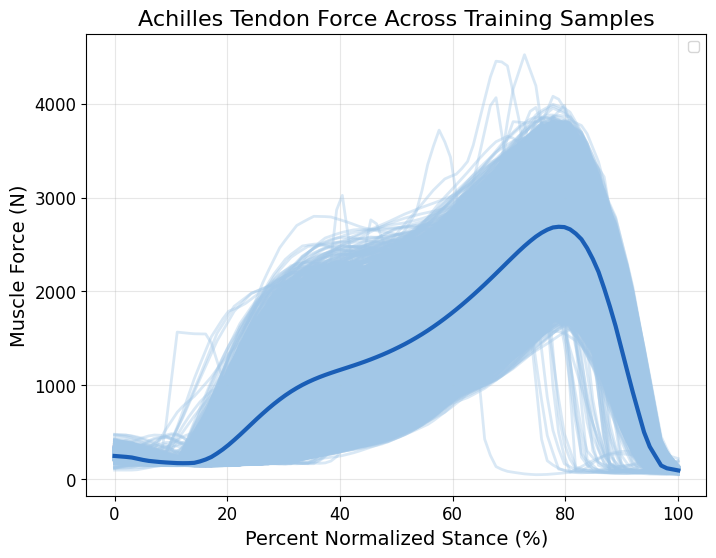

In [6]:
plot_achilles_force(y_train)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        
        # define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.25)
        
        # fully connected layer to map from hidden state to output features
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # pass through LSTM layer
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch, seq_length, hidden_size)
        
        # pass through fully connected layer to get the output
        output = self.fc(lstm_out)  # output shape: (batch, seq_length, output_size)
        
        return output



In [9]:
# model parameters
input_size = 3           # grf features (x, y, z)
hidden_size = 64         # hidden size for LSTM (tunable)
num_layers = 2           # number of LSTM layers
output_size = 9          # muscle force features

# create the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

In [10]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [11]:
# move the model to the device
model.to(device)

LSTMModel(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=64, out_features=9, bias=True)
)

In [12]:
from torch.utils.data import TensorDataset, DataLoader

# hyperparameters
num_epochs = 1000
learning_rate = 1e-3
batch_size = 32

# loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# convert your data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# create torch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# create dataloaders from datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# early stopping setup
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0

# training loop
for epoch in range(num_epochs):
    # set model to training mode
    model.train()
    
    # initialize training loss
    train_loss = 0
    
    # iterate over the training data
    for X_batch, y_batch in train_loader:
        # zero the gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # update training loss
        train_loss += loss.item() * X_batch.size(0)
    
    # average training loss over number of samples
    train_loss /= len(train_loader.dataset)
    
    # set model to evaluation mode
    model.eval()
    
    # initialize validation loss
    val_loss = 0
    
    # no need to calculate gradients during validation
    with torch.no_grad():
        # iterate over the validation data
        for X_batch, y_batch in val_loader:
            # forward pass
            outputs = model(X_batch)
            
            # calculate loss
            loss = criterion(outputs, y_batch)
            
            # update validation loss
            val_loss += loss.item() * X_batch.size(0)
    
    # average validation loss over number of samples
    val_loss /= len(val_loader.dataset)
    
    # print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
    # early stopping check
    if val_loss < best_val_loss:
        # save best validation loss
        best_val_loss = val_loss
        
        # reset epochs without improvement
        epochs_without_improvement = 0
    else:
        # increment epochs without improvement
        epochs_without_improvement += 1

    # break if patience limit is reached
    if epochs_without_improvement >= patience:
        break

Epoch [10/1000], Train Loss: 209493.7435, Val Loss: 207429.8230
Epoch [20/1000], Train Loss: 165259.3573, Val Loss: 163641.6687
Epoch [30/1000], Train Loss: 128416.0199, Val Loss: 127154.0524
Epoch [40/1000], Train Loss: 98061.3327, Val Loss: 97117.0649
Epoch [50/1000], Train Loss: 73521.0063, Val Loss: 72796.0958
Epoch [60/1000], Train Loss: 53976.7219, Val Loss: 53406.6199
Epoch [70/1000], Train Loss: 38807.5245, Val Loss: 38468.5577
Epoch [80/1000], Train Loss: 27356.9348, Val Loss: 27128.7004
Epoch [90/1000], Train Loss: 19007.2469, Val Loss: 18768.4171
Epoch [100/1000], Train Loss: 12992.9437, Val Loss: 13390.5057
Epoch [110/1000], Train Loss: 8869.6384, Val Loss: 8887.1444
Epoch [120/1000], Train Loss: 6196.2330, Val Loss: 6315.2312
Epoch [130/1000], Train Loss: 4654.8485, Val Loss: 4718.4347
Epoch [140/1000], Train Loss: 3769.2888, Val Loss: 3939.0497
Epoch [150/1000], Train Loss: 3332.2743, Val Loss: 3611.5088
Epoch [160/1000], Train Loss: 3066.6250, Val Loss: 3079.5732
Epoch [

In [14]:
# convert test data to torch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# set model to evaluation mode
model.eval()

# initialize test loss
test_loss = 0

# no need to calculate gradients during testing
with torch.no_grad():
    # forward pass
    test_outputs = model(X_test_tensor)
    
    # calculate loss
    test_loss = criterion(test_outputs, y_test_tensor).item()

# print test loss
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 2425.3481


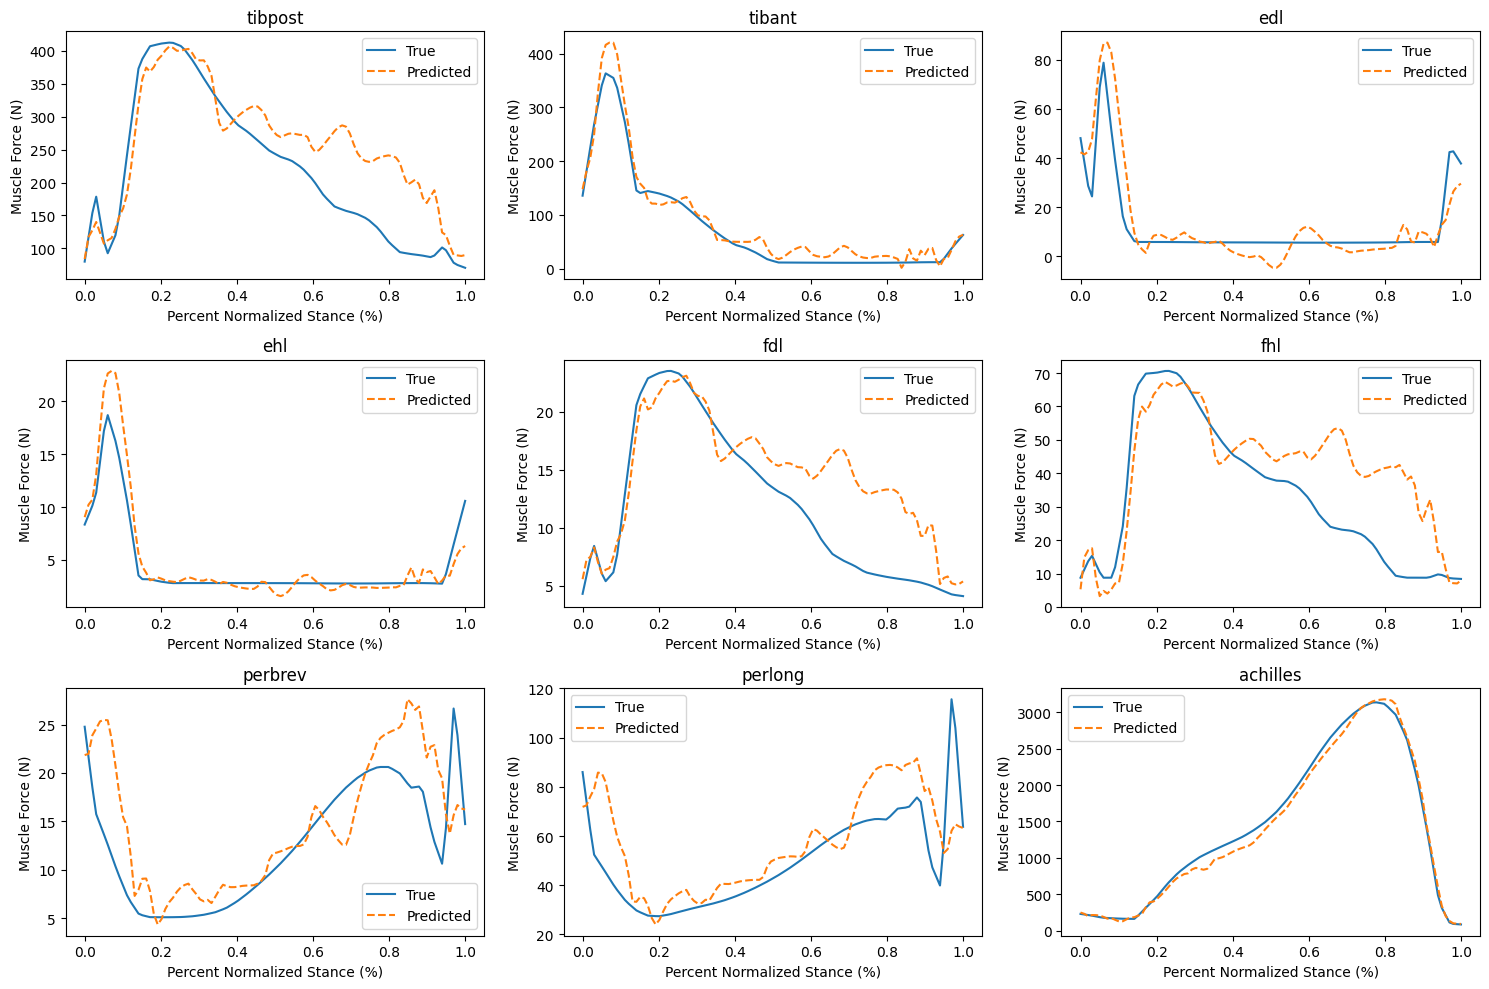

In [15]:
# Move predictions and ground truth to CPU for visualization
pred = test_outputs[0].cpu().numpy()  # Shape: (seq_length, 9)
true = y_test_tensor[0].cpu().numpy()      # Shape: (seq_length, 9)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Create subplots for 9 muscles
axes = axes.flatten()

for i in range(9):
    axes[i].plot(perc_stance, true[:, i], label="True")
    axes[i].plot(perc_stance, pred[:, i], label="Predicted", linestyle='dashed')
    axes[i].set_title(muscle_dict[i])
    axes[i].set_xlabel("Percent Normalized Stance (%)")
    axes[i].set_ylabel("Muscle Force (N)")
    axes[i].legend()

plt.tight_layout()
plt.show()